# Webscraping

In [1]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
import pandas as pd

C:\Users\Delbert\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Delbert\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\Delbert\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def webscraper(depth):
    # Final Dataframe
    final = pd.DataFrame.from_dict({"query": ["None"], "response": ["None"]})
    queries = []
    responses = []
    # Iterating through pages of forum
    for i in range(depth):
        # Finding all posts on forum page 
        url = "https://patient.info/forums/discuss/browse/depression-683?page={}#group-discussions".format(int(i))
        page = urlopen(Request(url, headers = {"User-Agent": "Mozilla/5.0"})).read()
        soup = BeautifulSoup(page, 'html.parser')
        
        href = [i["href"] for i in soup.find_all("a", href = True)]
        post_links = list(filter(lambda x:re.match(r"/forums/discuss/", x), href))
        post_links = list(set(post_links))
        
        # Iterating through every post on forum page
        for x in post_links:
            posturl = "https://patient.info/{}".format(str(x))
            postpage = urlopen(Request(posturl, headers = {"User-Agent": "Mozilla/5.0"})).read()
            soup = BeautifulSoup(postpage, 'html.parser')
            query = soup.find("div", {"class": "post__content"}).get_text()

            # Creating list in case of multiple responses
            temp = []
            
            for el in soup.findAll("div", {"class": "post__content break-word"}):
                temp.append(el.get_text())

            # Appending all responses to dataframe
            if len(temp) == 1:  
                queries.append(query)
                responses.append(temp[0])
            elif len(temp) > 1:
                for i in temp:
                    queries.append(query)
                    responses.append(str(i))
            else:
                queries.append("None")
                responses.append("None")
                
    final = final.append(pd.DataFrame.from_dict({"query": queries, "response": responses}), ignore_index = True)
    final.drop(0, inplace = True)

    return final, queries, responses
        

# Preprocessing

In [3]:
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize

%matplotlib inline

In [4]:
df = pd.read_csv("unprocessed_posts.csv")
df.head(10)

,query,response
0,"\n\nstarted on 50mg , dr increased to 100 mgdr...",\n\nhi Ingridare you taking sertraline? Someti...
1,\n\nBelow are listed recommended resources for...,\n\r\nawesome resource! thank you! ...
2,\n\nBelow are listed recommended resources for...,"\n\r\nThank you for this, I'm sure lots of peo..."
3,\n\nBelow are listed recommended resources for...,\n\r\nThanx for give informatic information fo...
4,\n\nBelow are listed recommended resources for...,\n\r\nYou are AMAZING for this! Thank you Hun....
5,\n\nHello everyone!\nI am now a couple a years...,"\n\nhi uzumak, i apologise if i have spelt you..."
6,\n\nHello everyone!\nI am now a couple a years...,"\n\nHi Uzumaki, I totally understand not wanti..."
7,"\n\nHello, thanks for reading and I apologize ...","\n\nHi Chantal, I can say quite categorically ..."
8,"\n\nHello, thanks for reading and I apologize ...","\n\r\nAw Chantal, you poor girl this sounds ve..."
9,"\n\nHello, thanks for reading and I apologize ...",\n\nHi ChantalAnxiety can cause us to doubt ev...


In [5]:
# Removing \n and likes/follow counts and Report/Delete text
df["query"] = df["query"].apply(lambda x: re.sub(r'[0-9]+ likes.*', '', re.sub(r'\n', ' ', x)))
df["response"] = df["response"].apply(lambda x: re.sub(r'Report.*', '', re.sub(r'\n', ' ', x)))

# # Removing anything that isn't a character
# df["query"] = df["query"].apply(lambda x: re.sub(r'[^a-zA-Z.]+', ' ', x))

# Removing pinned post
df.drop(df.index[1:5], inplace = True)
df.reset_index(drop = True, inplace = True)

# Removing links
df["query"] = df["query"].apply(lambda x: re.sub(r'http.*? ', ' ', x))

# Removing None's
df = df[df['query'] != "None"]

Mean query length:  236.88555489814894
Median query length:  170.0


Mean Response length:  94.49078691572986
Median Response length:  67.0


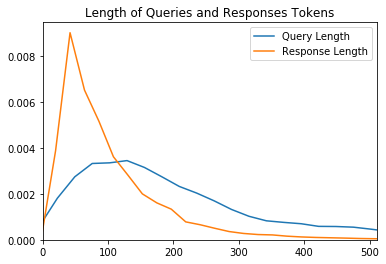

In [36]:
# Naive token assumptions (assuming space separates tokens)

token_len_query = [len(x) for x in [x.split(' ') for x in df["query"]]]
token_len_response = [len(x) for x in [x.split(' ') for x in df["response"]]]

print("Mean query length: ", str(sum(token_len_query)/len(token_len_query)))
print("Median query length: ", statistics.median(token_len_query))
print("\n")
print("Mean Response length: ", str(sum(token_len_response)/len(token_len_response)))
print("Median Response length: ", statistics.median(token_len_response))

g = sns.kdeplot(token_len_query, label = "Query Length")
g = sns.kdeplot(token_len_response, label = "Response Length")
g.set_title("Length of Queries and Responses Tokens")
g.set_xlim(0, 512)
plt.show()

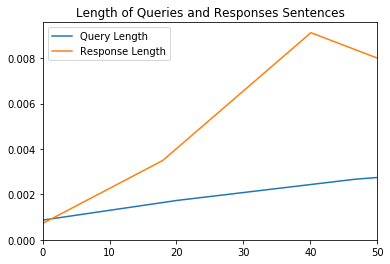

In [6]:
sent_len_query = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["query"]]]]
sent_len_query = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["response"]]]]

g = sns.kdeplot(token_len_query, label = "Query Length")
g = sns.kdeplot(token_len_response, label = "Response Length")
g.set_title("Length of Queries and Responses Sentences")
g.set_xlim(0, 50)
plt.show()

### Text Summarization

In [6]:
import time
import torch
from torch.autograd import Variable
import sys
sys.path.append("skip-thoughts.torch/pytorch")
from skipthoughts import DropUniSkip

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def summarize(forum_post, clusters=3, model_path = 'models/'):
    try: 
        # Tokenizing and Formatting
        sentences = sent_tokenize(forum_post)
        sentences = [re.sub(r'[^a-zA-Z.!?]', ' ', x) for x in sentences]

        dir_st = model_path
        post = [nltk.tokenize.word_tokenize(x) for x in sentences]
        vocab = list(set([word for sentence in post for word in sentence]))

        raw = []

        for sentence in post:
            temp = []
            for word in sentence:
                temp.append(vocab.index(str(word)))
            raw+=[temp]

        for x in raw:
            if len(x) < max([len(x) for x in raw]):
                x += ["0"]*(max([len(x) for x in raw])-len(x))

        final = []

        for sent in raw:
            temp = []
            for word in sent:
                temp.append(int(word))
            final += [temp]

        # Skipthought summarization
        x = Variable(torch.LongTensor(final))

        uniskip = DropUniSkip(dir_st, vocab)

        output = uniskip(x)
        output = output.detach().numpy()

        # Clustering and summarizing
        n_clusters = clusters
        kmeans = KMeans(n_clusters = n_clusters)
        kmeans = kmeans.fit(output)

        avg = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, output)
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        summary = ' '.join([sentences[closest[idx]] for idx in ordering])

        print(forum_post[0:50])
    
        return summary
    
    except: 
        return ("None")

# Scrap Code

In [35]:
import importlib
importlib.reload(skipthoughts)

<module 'skipthoughts' from 'C:\\Users\\Delbert\\Documents\\Kevin\\Masters\\Thesis\\skipthoughts.py'>